In [1]:
# Downloaded libraries
from matplotlib import pyplot as plt
import numpy as np
import pynwb

# Own libraries
import main

In [2]:
directory = "data\TestPlitt"

# # SHUFFLE RUN 0
# handledFiles = ["sub-F1_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F2_ses-20190417T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190211T210000_behavior+ophys_small.nwb",\
#                "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"]

# # SHUFFLE RUN 1
# handledFiles = ["sub-F2_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190418T210000_behavior+ophys_small.nwb",\
#                "sub-R2_ses-20190209T210000_behavior+ophys_small.nwb",\
#                "sub-R2_ses-20190221T210000_behavior+ophys_small.nwb"]

# # SHUFFLE RUN 2
# handledFiles = ["sub-F2_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb",\
#                "sub-R3_ses-20190211T210000_behavior+ophys_small.nwb",\
#                "sub-R3_ses-20190223T210000_behavior+ophys_small.nwb"]

# SHUFFLE RUN 3
handledFiles = ["sub-F5_ses-20190407T210000_behavior+ophys_small.nwb",\
               "sub-F2_ses-20190416T210000_behavior+ophys_small.nwb",\
               "sub-R4_ses-20190824T210000_behavior+ophys_small.nwb",\
               "sub-R4_ses-20190905T210000_behavior+ophys_small.nwb"]

In [3]:
nNeurons = {}
deconvTraces = {}
startIndices = {}
baseMorph = {}
position = {}
nTrials = {}

readFiles = [main.getSessionHandle(file, directory) for file in handledFiles]
nFiles = len(readFiles)

for i, file in enumerate(readFiles):
    data = main.dataExtraction(readFiles[i].read())

    # nFrames = data["nFrames"]
    nNeurons[i] = data["nNeurons"]
    deconvTraces[i] = data["deconvTraces"]
    # tstartData = data["tstartData"]
    nTrials[i] = data["nTrials"]
    startIndices[i] = data["startIndices"]
    baseMorph[i] = data["baseMorph"]
    # totalMorph = data["totalMorph"]
    position[i] = data["position"]

In [4]:
dbs = {}
pbs = {}
shifted_pbs = {}
df = {}
occp = {}

for i in range(nFiles):
    dbs[i], pbs[i] = main.trialize(deconvTraces[i], position[i], startIndices[i])
    df[i], occp[i] = main.positionalBin(dbs[i], pbs[i])

In [5]:
SIMatrix = {i:np.zeros((nNeurons[i], 5)) for i in range(nFiles)}
baseMorphList = {i:baseMorph[i][startIndices[i]] for i in range(nFiles)} 
 
for sess in range(nFiles):
    for i in range(nNeurons[sess]):
        SIMatrix[sess][i,:] = main.getSpatialInformation(df[sess][:,:,i], occp[sess], baseMorphList[sess])
       

### Load in the data for SI Masks (significance check)

In [9]:
loaded_data = np.load(f'shufflerun3.npz')
fNames = [filename for filename in loaded_data]
SIShuffles = {i:loaded_data[fname] for i, fname in enumerate(fNames)}
SIMasks = {i:np.percentile(SIs, 95, axis=0) for i, SIs in enumerate(SIShuffles.values())}

# This part can be manipulated to extract sessions from different saved files

### Place cell percentage of total cell count
#### Simple method not taking into account each individual morph

In [10]:
placeCellProp = {i:np.mean(SIMatrix[i] > SIMasks[i])*100 for i in range(nFiles)}
print(f'From shuffling analysis, using SIMatrix as mask:\n{placeCellProp}')


From shuffling analysis, using SIMatrix as mask:
{0: 19.182915506035283, 1: 26.09200968523002, 2: 23.36, 3: 49.26078028747433}


#### Counting place cell amount for every individual morph

In [76]:
# Creating variable that stores the indices of the place cells (per file per basemorph)

placeCellInds = {}

for sess in range(nFiles):
    placeCellInds[sess] = {morph:np.where(SIMatrix[sess][:,m] > SIMasks[sess][:,m])[0] for m, morph in enumerate(main.baseMorphValues)}

In [77]:
placeCellCounts = {}
for sess in range(nFiles):
    placeCellCounts[sess] = {morph:len(placeCellInds[sess][morph]) for morph in main.baseMorphValues}


for sess in range(nFiles):
    print(f'\nFor session {sess}:')
    for morph in main.baseMorphValues:
        placeCellPct = placeCellCounts[sess][morph]*100/nNeurons[sess]
        print(f"For base morph {morph}:\t {placeCellCounts[sess][morph]} place cells, \t {placeCellPct:.2f}% of all ROIs")



For session 0:
For base morph 0.0:	 191 place cells, 	 17.73% of all ROIs
For base morph 0.25:	 215 place cells, 	 19.96% of all ROIs
For base morph 0.5:	 201 place cells, 	 18.66% of all ROIs
For base morph 0.75:	 239 place cells, 	 22.19% of all ROIs
For base morph 1.0:	 187 place cells, 	 17.36% of all ROIs

For session 1:
For base morph 0.0:	 684 place cells, 	 33.12% of all ROIs
For base morph 0.25:	 447 place cells, 	 21.65% of all ROIs
For base morph 0.5:	 487 place cells, 	 23.58% of all ROIs
For base morph 0.75:	 499 place cells, 	 24.16% of all ROIs
For base morph 1.0:	 577 place cells, 	 27.94% of all ROIs

For session 2:
For base morph 0.0:	 457 place cells, 	 28.12% of all ROIs
For base morph 0.25:	 430 place cells, 	 26.46% of all ROIs
For base morph 0.5:	 326 place cells, 	 20.06% of all ROIs
For base morph 0.75:	 283 place cells, 	 17.42% of all ROIs
For base morph 1.0:	 402 place cells, 	 24.74% of all ROIs

For session 3:
For base morph 0.0:	 626 place cells, 	 64.27

### Place field location (peak location) for each area of importance (three)

In [93]:
# Needed, activity the place cells ONLY for each morph

df_placeCells = {}
baseIndices = {}
avgActivity = {}

for sess in range(nFiles):
    # extracts the sub-dataframes for the place cells for each basemorph value (all trials)
    df_placeCells[sess] = {morph:df[sess][:,:,placeCellInds[sess][morph]] for morph in main.baseMorphValues}

    # gets the indices of the trials at each base morph value
    baseIndices[sess] = {morph:np.where(baseMorphList[sess] == morph)[0] for morph in main.baseMorphValues}

    avgActivity[sess] = {morph:{} for morph in main.baseMorphValues}
    for cells in main.baseMorphValues:
        for trials in main.baseMorphValues:
            bInds = baseIndices[sess][trials]
            num = np.sum(df_placeCells[sess][cells][bInds], axis = 0)
            den = np.sum(occp[sess][bInds], axis = 0).reshape(-1,1)
            avgActivity[sess][cells][trials] = num / den


In [160]:
peaks = {}
rewardPeaks = {sess:{} for sess in range(nFiles)}
begPeaks = {sess:{} for sess in range(nFiles)}
otherPeaks = {sess:{} for sess in range(nFiles)}

for sess in range(nFiles):
    peaks[sess] = {morph:np.argmax(avgActivity[sess][morph][morph],axis=0) for morph in main.baseMorphValues}
    
    print(f"\nFor session {sess}:")
    for morph in main.baseMorphValues:
        b_region = sum(peaks[sess][morph] < 5)
        r_region = sum((25 < peaks[sess][morph]) & (peaks[sess][morph] < 40))
        o_region = len(peaks[sess][morph]) - b_region - r_region
        rewardPeaks[sess][morph] = r_region
        begPeaks[sess][morph] = b_region
        otherPeaks[sess][morph] = o_region
    
#         print(f"For base morph {morph}:\t {100*rewardPeaks[sess][morph]/placeCellCounts[sess][morph]:.2f} % cells tuned for reward region ({rewardPeaks[sess][morph]} cells)") 
        print(f"For base morph {morph}:\t Reward: {100*rewardPeaks[sess][morph]/placeCellCounts[sess][morph]:.2f} % ({rewardPeaks[sess][morph]} cells)",end="\t")
        print(f"Beginning: {100*begPeaks[sess][morph]/placeCellCounts[sess][morph]:.2f} % ({begPeaks[sess][morph]} cells)",end="\t")
        print(f"Other: {100*otherPeaks[sess][morph]/placeCellCounts[sess][morph]:.2f} % ({otherPeaks[sess][morph]} cells)")
        

# sum((25 < peaks[3][0]) & (peaks[3][0] < 40))
# rPeaksArr = np.array([peaks for peaks in rewardPeaks[3].values()])
# bPeaksArr = np.array([peaks for peaks in begPeaks[3].values()])
# oPeaksArr = np.array([peaks for peaks in otherPeaks[3].values()])
# print(rPeaksArr/15)
# print(bPeaksArr/5)
# print(oPeaksArr/25)




For session 0:
For base morph 0.0:	 Reward: 40.31 % (77 cells)	Beginning: 12.57 % (24 cells)	Other: 47.12 % (90 cells)
For base morph 0.25:	 Reward: 42.33 % (91 cells)	Beginning: 8.84 % (19 cells)	Other: 48.84 % (105 cells)
For base morph 0.5:	 Reward: 38.31 % (77 cells)	Beginning: 7.96 % (16 cells)	Other: 53.73 % (108 cells)
For base morph 0.75:	 Reward: 34.31 % (82 cells)	Beginning: 14.64 % (35 cells)	Other: 51.05 % (122 cells)
For base morph 1.0:	 Reward: 33.16 % (62 cells)	Beginning: 10.70 % (20 cells)	Other: 56.15 % (105 cells)

For session 1:
For base morph 0.0:	 Reward: 42.54 % (291 cells)	Beginning: 14.18 % (97 cells)	Other: 43.27 % (296 cells)
For base morph 0.25:	 Reward: 45.19 % (202 cells)	Beginning: 13.42 % (60 cells)	Other: 41.39 % (185 cells)
For base morph 0.5:	 Reward: 44.35 % (216 cells)	Beginning: 14.37 % (70 cells)	Other: 41.27 % (201 cells)
For base morph 0.75:	 Reward: 47.49 % (237 cells)	Beginning: 15.23 % (76 cells)	Other: 37.27 % (186 cells)
For base morph 1.0

### Place field histogram plot, Occupancy plot, Normalized Plot

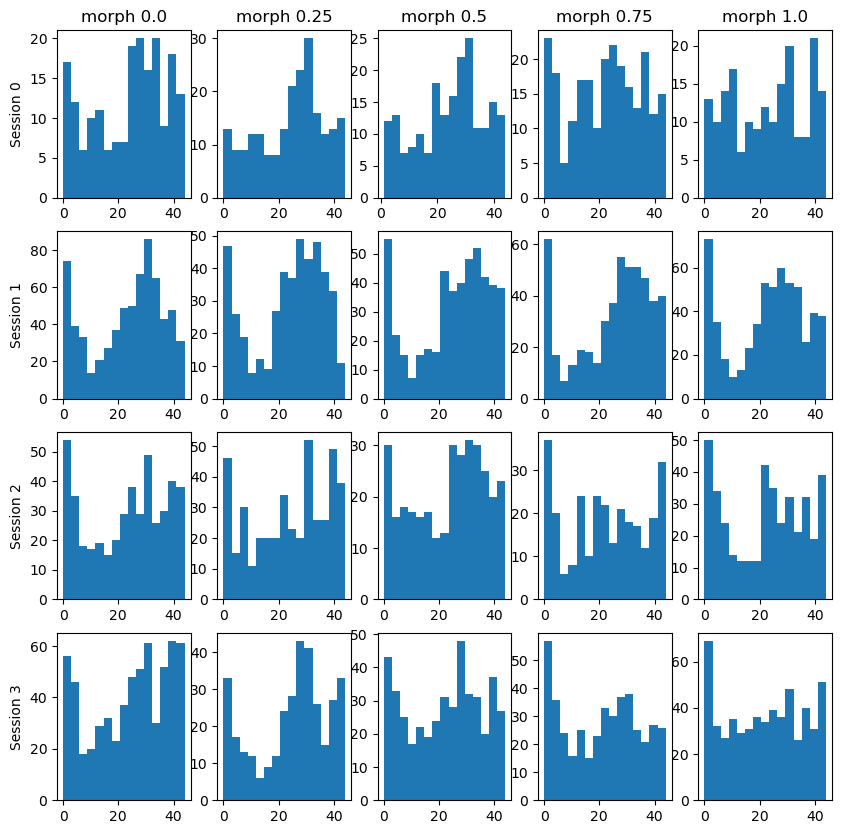

In [182]:
# Histogram
fig, ax = plt.subplots(nFiles, 5, figsize=(10,10))
for row in range(nFiles):
    for col, morph in enumerate(main.baseMorphValues):
        ax[row,col].hist(peaks[row][morph], bins = 15)
        if col == 0:
            ax[row,col].set_ylabel(f'Session {row}')
        if row == 0:
            ax[row,col].set_title(f'morph {morph}')
    
            

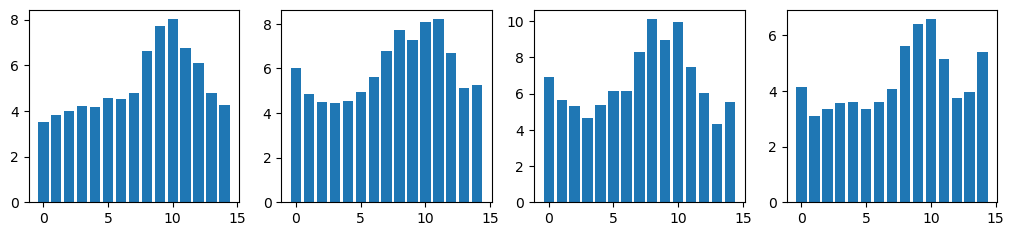

In [178]:
# Occupancy
fig, ax = plt.subplots(1, nFiles, figsize=(12.5,2.5))

for sess in range(nFiles):
    toPlot = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1) # inner reshape and mean is to discretoze the array into 15 bins
    ax[sess].bar(range(15),toPlot)

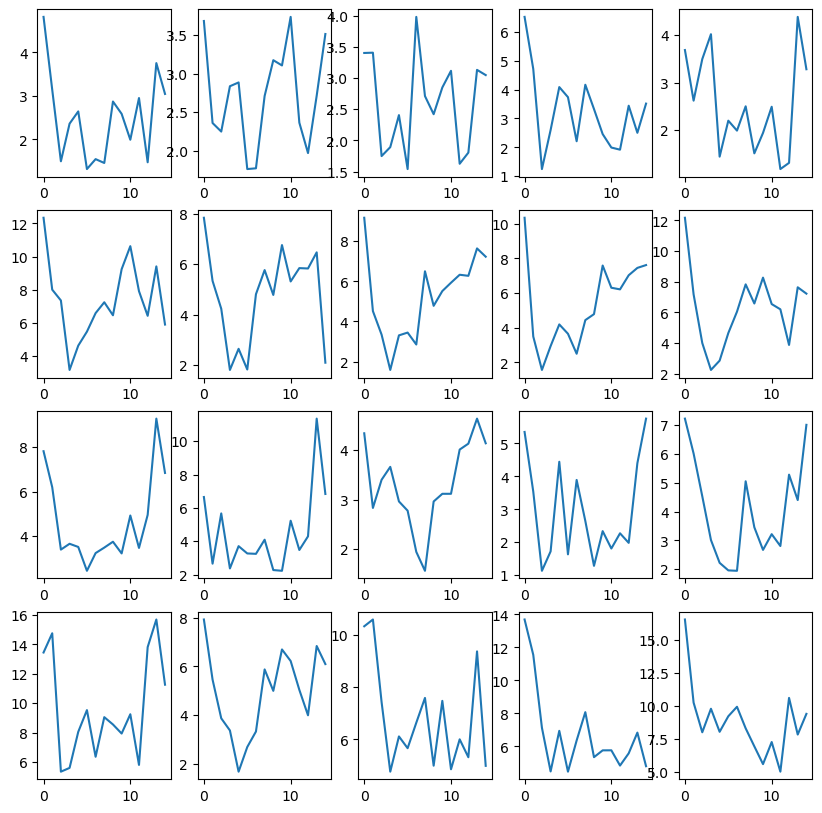

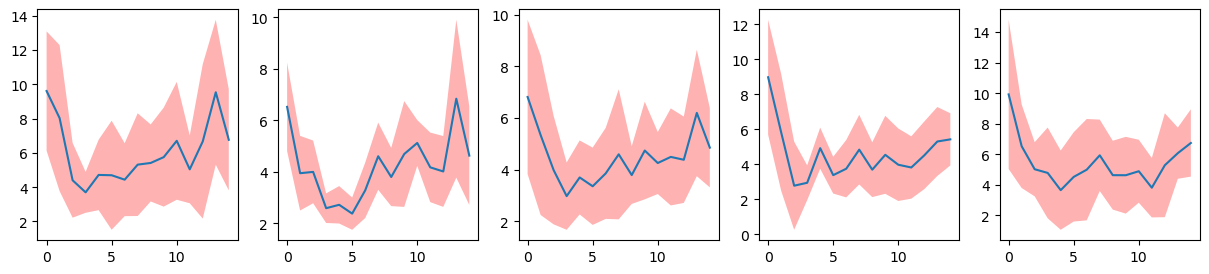

In [184]:
# Plotting the cell count normalized by the average occupancy for every session (for all basemorphs)
fig, ax = plt.subplots(nFiles,len(main.baseMorphValues), figsize=(10,10))

avgcellToOccpR = {}
for sess in range(nFiles):
    for i, morph in enumerate(main.baseMorphValues):
        cellCounts = np.histogram(np.argmax(avgActivity[sess][morph][morph],axis=0),bins=15)[0]
        binnedPos = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1)
        ax[sess][i].plot(cellCounts/binnedPos)
        if sess == 0:
            avgcellToOccpR[morph] = cellCounts/binnedPos
        else:
            avgcellToOccpR[morph] = np.vstack((avgcellToOccpR[morph], cellCounts/binnedPos))
            
# Plotting the average normalized cell count across sessions
fig, ax = plt.subplots(1,5, figsize=(15,3))
for i, morph in enumerate(main.baseMorphValues):
    means = np.mean(avgcellToOccpR[morph],axis=0)
    stds = np.std(avgcellToOccpR[morph],axis=0)
    ax[i].plot(range(15),means)
    ax[i].fill_between(range(15),means-stds,means+stds,alpha=0.3,facecolor='red')

### Intrasessional remapping

### Intersessional remapping